# Landscape change plots

In [ ]:
import tempfile
from os import path

import matplotlib.pyplot as plt
import numpy as np
import pylandstats as pls
import rasterio as rio
import seaborn as sns
import swisslandstats as sls
from matplotlib import colors
from mpl_toolkits.basemap import Basemap
from rasterio import transform as rio_transform, warp as rio_warp

from swiss_urbanization.data import settings

In [ ]:
urban_class = settings.EXTRACTS_URBAN
nonurban_class = settings.EXTRACTS_NONURBAN
nodata = settings.EXTRACTS_NODATA

# for Basemap
epsg = 4326
plot_crs = {'init': f'epsg:{epsg}'}

agglomeration_slugs = ['bern', 'lausanne', 'zurich']

In [ ]:
agglomeration_dict = {}
bounds_dict = {}
for agglomeration_slug in agglomeration_slugs:
    ldf = sls.read_csv(
        f'../data/processed/agglomeration_extracts/{agglomeration_slug}.csv')
    landscapes = []
    dates = []
    # TODO: rebase as heat-tail design pattern to avoid calling
    # `calculate_default_transform` repeatedly
    for urban_nonurban_column in ldf.columns[ldf.columns.str.startswith('AS')]:
        with tempfile.TemporaryDirectory() as tmpdirname:
            src_fp = path.join(tmpdirname, 'src')
            dst_fp = path.join(tmpdirname, 'dst')
            ldf.to_geotiff(src_fp, urban_nonurban_column, nodata=nodata)
            with rio.open(src_fp) as src:
                transform, width, height = \
                    rio_warp.calculate_default_transform(
                        src.crs, plot_crs, src.width, src.height, *src.bounds)
                kwargs = src.meta.copy()
                kwargs.update({
                    'crs': plot_crs,
                    'transform': transform,
                    'width': width,
                    'height': height
                })
                with rio.open(dst_fp, 'w', **kwargs) as dst:
                    rio_warp.reproject(
                        source=rio.band(src, 1),
                        destination=rio.band(dst, 1),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=plot_crs)
                    if agglomeration_slug not in bounds_dict:
                        bounds_dict[agglomeration_slug] = dst.bounds
            landscapes.append(pls.Landscape(dst_fp))
        # get the year of the snapshot by taking the most recurrent timestamp
        # (year) among the pixels
        dates.append(
            ldf['FJ' + urban_nonurban_column[2:4]].value_counts().index[0])
    agglomeration_dict[agglomeration_slug] = pls.SpatioTemporalAnalysis(
        landscapes, dates=dates)

In [ ]:
min_width = 0
min_height = 0

for agglomeration_slug in agglomeration_slugs:
    west, south, east, north = bounds_dict[agglomeration_slug]
    width = east - west
    if width > min_width:
        min_width = width
    height = north - south
    if height > min_height:
        min_height = height

/home/martibosch/anaconda3/envs/swiss-urbanization/lib/python3.6/site-packages/owslib/map/wms111.py:128: UserWarning: Content metadata for layer "ch.bakom.notruf-118_mobilnetz" already exists. Using child layer
  warnings.warn('Content metadata for layer "%s" already exists. Using child layer' % cm.id)


/home/martibosch/anaconda3/envs/swiss-urbanization/lib/python3.6/site-packages/owslib/map/wms111.py:128: UserWarning: Content metadata for layer "ch.bakom.notruf-118_mobilnetz" already exists. Using child layer
  warnings.warn('Content metadata for layer "%s" already exists. Using child layer' % cm.id)


/home/martibosch/anaconda3/envs/swiss-urbanization/lib/python3.6/site-packages/owslib/map/wms111.py:128: UserWarning: Content metadata for layer "ch.bakom.notruf-118_mobilnetz" already exists. Using child layer
  warnings.warn('Content metadata for layer "%s" already exists. Using child layer' % cm.id)


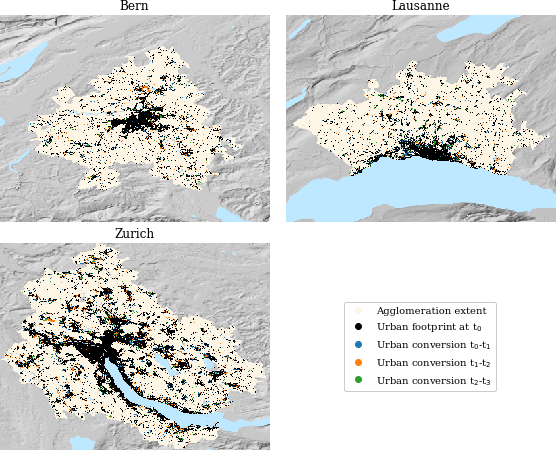

In [ ]:
num_cols = 2
num_agglomerations = len(agglomeration_slugs)
num_rows = num_agglomerations // num_cols
if num_agglomerations % num_cols > 0:
    num_rows += 1
  
# plt.rcParams['axes.edgecolor'] = (0,0,0,0)
# plt.rcParams['axes.facecolor'] = (0,0,0,0)
agglmeration_extent_color = colors.to_rgba(colors.cnames['oldlace'], alpha=1)
base_cmap = colors.LinearSegmentedColormap.from_list(
    'binaryalpha', [(0, 0, 0, 0), (0, 0, 0, 1), agglmeration_extent_color], 3)

delta_x = 0  # 0.01
delta_y = 0  # 0.01

# get default plot dimensions to be used below
figwidth, figheight = plt.rcParams['figure.figsize']    
fig = plt.figure(figsize=(num_rows * 5, num_cols * figheight))
fig.subplots_adjust(hspace=0.1, wspace=0.05)

for i, agglomeration_slug in enumerate(agglomeration_slugs, start=1):
    ax = fig.add_subplot(num_rows, num_cols, i)
    ax.axis('off')
    ax.set_title(agglomeration_slug.capitalize())

    landscapes = agglomeration_dict[agglomeration_slug].landscapes
    landscape_arr = landscapes[0].landscape_arr
    landscape_height, landscape_width = landscape_arr.shape
    west, south, east, north = bounds_dict[agglomeration_slug]

    horizontal_margin = (min_width - (east - west)) / 2 + delta_x
    vertical_margin = (min_height - (north - south)) / 2 + delta_y
    _west = west - horizontal_margin
    _south = south - vertical_margin
    _east = east + horizontal_margin
    _north = north + vertical_margin

    m = Basemap(
        epsg=epsg,
        llcrnrlon=_west,
        llcrnrlat=_south,
        urcrnrlon=_east,
        urcrnrlat=_north,
        ax=ax)
    img = m.wmsimage(
        'https://image.discomap.eea.europa.eu/arcgis/services/Elevation/'
        'Hillshade/MapServer/WmsServer?',
        layers=['Image'])
    img.set_array(img.get_array().dot([.07, .72, .21]))
    img.set_cmap('gray')
    ax._sci(img)
    m.wmsimage(
        'https://wms.geo.admin.ch/?',
        layers=['ch.bafu.gefahren-basiskarte.lakes'],
        transparent=True)

    row_start, col_start = rio_transform.rowcol(
        rio_transform.from_origin(
            _west, _north, (east - west) / landscape_width,
            (north - south) / landscape_height), west, north)
    plt_arr = np.zeros(
        (landscape_height + 2 * row_start, landscape_width + 2 * col_start),
        dtype=np.uint8)
    landscape_slices = slice(row_start, row_start + landscape_height), slice(
        col_start, col_start + landscape_width)
    plt_arr[landscape_slices] = landscape_arr
    m.imshow(plt_arr, cmap=base_cmap, origin='upper', ax=ax)

    color_palette_iter = iter(sns.color_palette())
    for i in range(len(landscapes) - 1):
        change_arr = (landscapes[i + 1].landscape_arr == urban_class) & (
            landscapes[i].landscape_arr != urban_class)
        plt_arr = np.zeros_like(plt_arr)
        plt_arr[landscape_slices] = change_arr
        r, g, b = next(color_palette_iter)
        m.imshow(
            plt_arr,
            cmap=colors.LinearSegmentedColormap.from_list(
                i, [(0, 0, 0, 0), (r, g, b, 1)], 2),
            origin='upper',
            ax=ax)

# generate a legend and place it in the last (empty) axis
ax = fig.add_subplot(num_rows, num_cols, 4)
ax.axis('off')
ax.plot(0, 0, 'o', c=agglmeration_extent_color, label='Agglomeration extent')
ax.plot(0, 0, 'o', c=(0, 0, 0), label=f'Urban footprint at t$_0$')
color_palette_iter = iter(sns.color_palette())
for i in range(len(landscapes[:-1])):
    r, g, b = next(color_palette_iter)
    ax.plot(
        0, 0, 'o', c=(r, g, b), label=f'Urban conversion t$_{i}$-t$_{i+1}$')
ax.legend(loc='center', facecolor='white', framealpha=1)

fig.savefig('../reports/figures/landscape_plots.pdf')